In [3]:
import pandas as pd

import dask
import dask.dataframe as dd
from dask.distributed import Client, LocalCluster
import multiprocessing.popen_spawn_win32

In [2]:
#start a local dask cluster
cluster = LocalCluster(n_workers=4)
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:8983 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 12 Memory: 34.27 GB


In [12]:
#read data
sys_info = pd.read_csv('D:/180B/data/system_sysinfo_unique_normalized.csv000',
                       delimiter ="\1")
sys_info.head()

,load_ts,guid,chassistype,chassistype_2in1_category,countryname,countryname_normalized,modelvendor,modelvendor_normalized,model,model_normalized,...,cpu_suffix,screensize_category,persona,processor_line,vpro_enabled,firstreportdate,lastreportdate,discretegraphics,cpu_stepping,engagement_id
0,2020-10-01 00:48:15,10351643a4ae4b2d9cbc8a90db184050,Notebook,Unknown,Brazil,Brazil,Lenovo,Lenovo,Lenovo G480,Lenovo G480,...,Core-M,14x,Web User,M-Processor,N,2020-01-12 20:31:03,2020-09-29 18:30:56,N,Intel64 Family 6 Model 42 Stepping 7,iduu
1,2020-10-01 00:48:15,4f40b2f38cd74f6ea1559cebbc924619,Notebook,Unknown,Sweden,Sweden,Asus,Asus,T300CHI,T300CHI,...,Core-Y,12x,Web User,Unknown,N,2018-11-15 17:24:52,2020-09-28 12:49:29,N,Intel64 Family 6 Model 61 Stepping 4,iduu
2,2020-10-01 00:48:15,04b81eb4d661410ebff356f27fc544ed,Desktop,Unknown,Viet Nam,Viet Nam,System manufacturer,System manufacturer,System Product Name,System Product Name,...,Other,23x,Office/Productivity,Unknown,Y,2020-05-09 12:24:37,2020-09-29 08:54:35,Y,Intel64 Family 6 Model 158 Stepping 12,intel.com
3,2020-10-01 00:48:15,afd55a587fe14fc1904d572b3230dd54,Notebook,Unknown,Mexico,Mexico,HP,HP,HP ProBook 640 G2,HP ProBook 640 G2,...,Core-U,14x,Office/Productivity,U-Processor,N,2019-10-22 13:56:27,2020-09-28 08:41:47,N,Intel64 Family 6 Model 78 Stepping 3,intel.com
4,2020-10-01 00:48:15,4b3d6747c5f541949f4c1bd127b00bd9,Notebook,Unknown,Romania,Romania,Acer,Acer,Nitro AN515-52,Nitro AN515-52,...,Core-H,15x,Web User,H-Processor,N,2020-04-01 17:37:46,2020-04-23 19:34:16,Y,Intel64 Family 6 Model 158 Stepping 10,intel.com


In [13]:
df = sys_info.copy()

In [15]:
used_cols =['chassistype',
                'chassistype_2in1_category',
                'countryname_normalized',
                'modelvendor_normalized',
                'model_normalized',
                'ram',
                'os',
                '#ofcores',
                'age_category',
                'graphicsmanuf',
                'graphicscardclass',
                'processornumber',
                'cpuvendor',
                'cpu_family',
                'cpu_suffix',
                'screensize_category',
                'persona',
                'processor_line',
                'vpro_enabled',
                'discretegraphics']
df = sys_info[used_cols]

    #cleaning
df = df.dropna()
df = df[df.persona!= 'Unknown'].reset_index(drop=True)
df = df[df.processornumber!= 'Unknown'].reset_index(drop=True)


df['processornumber'] = df['processornumber'].apply(lambda x: x[:2] ).astype('int32',errors='raise')
df['ram'] =df['ram'].astype('int32')
df['#ofcores'] =df['#ofcores'].astype('int32',errors='raise')

    #define the columns with different type
used_cols.remove('persona')
int_cols = ['ram','#ofcores','processornumber']
cat_cols = [i for i in used_cols if i not in int_cols]

In [16]:
df.head()

,chassistype,chassistype_2in1_category,countryname_normalized,modelvendor_normalized,model_normalized,ram,os,#ofcores,age_category,graphicsmanuf,graphicscardclass,processornumber,cpuvendor,cpu_family,cpu_suffix,screensize_category,persona,processor_line,vpro_enabled,discretegraphics
0,Notebook,Unknown,Brazil,Lenovo,Lenovo G480,12,Win10,2,6+ years,Intel,Low-End Graphics Cards,32,Intel,Core i3,Core-M,14x,Web User,M-Processor,N,N
1,Notebook,Unknown,Sweden,Asus,T300CHI,8,Win10,2,5-6 years,Intel,Low-End Graphics Cards,14,Intel,Core M,Core-Y,12x,Web User,Unknown,N,N
2,Desktop,Unknown,Viet Nam,System manufacturer,System Product Name,8,Win10,8,0-1 year,Intel,Low-Midrange Graphics Cards,14,Intel,Core i7,Other,23x,Office/Productivity,Unknown,Y,Y
3,Notebook,Unknown,Mexico,HP,HP ProBook 640 G2,8,Win10,2,3-4 years,Intel,Low-Midrange Graphics Cards,14,Intel,Core i5,Core-U,14x,Office/Productivity,U-Processor,N,N
4,Notebook,Unknown,Romania,Acer,Nitro AN515-52,16,Win10,4,1-2 years,Nvidia,Mid-Range Graphics Cards,14,Intel,Core i5,Core-H,15x,Web User,H-Processor,N,Y


In [17]:
cat_cols

['chassistype',
 'chassistype_2in1_category',
 'countryname_normalized',
 'modelvendor_normalized',
 'model_normalized',
 'os',
 'age_category',
 'graphicsmanuf',
 'graphicscardclass',
 'cpuvendor',
 'cpu_family',
 'cpu_suffix',
 'screensize_category',
 'processor_line',
 'vpro_enabled',
 'discretegraphics']

In [19]:
pd.crosstab(df.persona,df.chassistype)

chassistype,2 in 1,Desktop,Intel NUC/STK,Notebook,Tablet
persona,,,,,
Casual Gamer,365,3514,54,4939,0
Casual User,434,4414,402,5859,0
Communication,443,1720,241,2499,1
Content Creator/IT,289,1789,120,2820,0
Entertainment,144,1146,85,1978,0
File & Network Sharer,93,714,125,963,0
Gamer,320,3460,82,4770,3
Office/Productivity,562,1863,197,4059,0
Web User,2002,10109,662,18602,6


## Chi Square Tests On categorical features

In [19]:
from scipy.stats import chi2_contingency
def data_cleaning(df):
    used_cols =['chassistype',
                'chassistype_2in1_category',
                'countryname_normalized',
                'modelvendor_normalized',
                'model_normalized',
                'ram',
                'os',
                '#ofcores',
                'age_category',
                'graphicsmanuf',
                'graphicscardclass',
                'processornumber',
                'cpuvendor',
                'cpu_family',
                'cpu_suffix',
                'screensize_category',
                'persona',
                'processor_line',
                'vpro_enabled',
                'discretegraphics']
    df = df[used_cols]

    #cleaning
    df = df.dropna()
    df = df[df.persona!= 'Unknown'].reset_index(drop=True)
    df = df[df.processornumber!= 'Unknown'].reset_index(drop=True)

    df['processornumber'] = df['processornumber'].apply(lambda x: x[:2] ).astype('int32',errors='raise')
    df['ram'] =df['ram'].astype('int32')
    df['#ofcores'] =df['#ofcores'].astype('int32',errors='raise')
    
    return df

    
def chi_square_test(data_path,alpha):
    
    #read the data
    sys_info = pd.read_csv(data_path, delimiter ="\1")
    
    #clean the data
    df = data_cleaning(sys_info)
    
    
    
    cat_cols = ['chassistype',
                'chassistype_2in1_category',
                'countryname_normalized',
                'modelvendor_normalized',
                'model_normalized',
                'os',
                'age_category',
                'graphicsmanuf',
                'graphicscardclass',
                'cpuvendor',
                'cpu_family',
                'cpu_suffix',
                'screensize_category',
                'processor_line',
                'vpro_enabled',
                'discretegraphics']
    out_df = {}
    for i in cat_cols:
        #create a crosstable of that categorical feature
        ct = pd.crosstab(df.persona,df[i])
        
        #chi square tests
        stat, p, dof, expected = chi2_contingency(ct)
        
        out_df[i] = p
        
        # interpret p-value
        #print("p value between the persona and "+i+" is: " + str(p)) 
        if p <= alpha: 
            #print('They are dependent (reject H0)') 
            pass
        else: 
            #print('They are independent (H0 holds true)')
            pass
        
    out_df = pd.DataFrame.from_dict(out_df,orient='index',columns=['p-values'])
    return out_df



<AxesSubplot:>

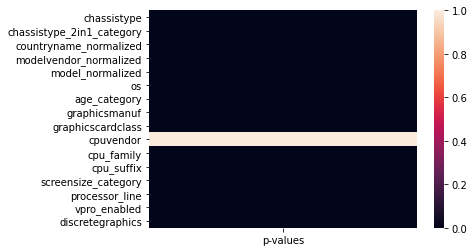

In [20]:
r = chi_square_test('../cleaned_data/system_sysinfo_unique_normalized.csv000',0.05)
import seaborn as sns
ax = sns.heatmap(r)
ax

## Paired T-tests On Numerical Features

In [7]:
sys_info.persona.value_counts().compute()

Web User                 35153
Casual User              12810
Gamer                    10611
Casual Gamer             10498
Office/Productivity       7519
Content Creator/IT        5883
Communication             5836
Win Store App User        4968
Entertainment             3768
File & Network Sharer     2231
Unknown                    723
Name: persona, dtype: int64

In [8]:
import pandas as pd
import dask
import dask.dataframe as dd
import scipy.stats as stats

def hypo_test_on_numerical(datapath, feature):
    # This function finds all pvalues between each persona with the given feature
    
    data = dd.read_csv(datapath,
                       delimiter ="\1",
                       assume_missing=True)
    results = {}
    
    #list for all types of users
    all_persona = list(data.persona.unique().compute())
    all_persona.remove('Unknown')
    print(all_persona)
    # test between all personas
    for i in all_persona:
        # data of ram of persona i
        d1 = data.loc[data['persona'] == i][feature]
        for j in all_persona:
            if (i,j) not in results.keys() and (i !=j):
                # data of persona i
                d2 = data.loc[data['persona'] == j][feature]
                #testing
                output = stats.ttest_ind(a = d1, b = d2)
                #put into results dict
                results[(i,j)] = output.pvalue
            else:
                pass
                
    return results

def unsignificants(results_dict, significant_level):
    # This function finds all unsignificant values in the results list
    unsig = {}
    keys = results_dict.keys()
    for i in keys:
        if results_dict[i] > significant_level:
            unsig[i] = results_dict[i]
    return unsig

In [9]:
results = hypo_test_on_numerical('D:/180B/data/system_sysinfo_unique_normalized.csv000.gz', 'ram')

c:\users\yxx726\appdata\local\programs\python\python36\lib\site-packages\dask\dataframe\io\csv.py:481: UserWarning: Warning gzip compression does not support breaking apart files
Please ensure that each individual file can fit in memory and
use the keyword ``blocksize=None to remove this message``
Setting ``blocksize=None``
  "Setting ``blocksize=None``" % compression


['Web User', 'Office/Productivity', 'Casual Gamer', 'Entertainment', 'Communication', 'Casual User', 'Gamer', 'Content Creator/IT', 'Win Store App User', 'File & Network Sharer']


In [10]:
unsig_results = unsignificants(results,0.05)

In [11]:
results

{('Web User', 'Office/Productivity'): 3.766131469002691e-06,
 ('Web User', 'Casual Gamer'): 5.583512828016116e-63,
 ('Web User', 'Entertainment'): 0.042265218754574924,
 ('Web User', 'Communication'): 2.2534434999585363e-11,
 ('Web User', 'Casual User'): 2.661729093536839e-13,
 ('Web User', 'Gamer'): 2.102470376967744e-48,
 ('Web User', 'Content Creator/IT'): 1.1590440486812365e-113,
 ('Web User', 'Win Store App User'): 8.05188809009119e-07,
 ('Web User', 'File & Network Sharer'): 0.0007158699064106796,
 ('Office/Productivity', 'Web User'): 3.766131469002691e-06,
 ('Office/Productivity', 'Casual Gamer'): 1.6409166939962495e-58,
 ('Office/Productivity', 'Entertainment'): 1.3102094611601196e-05,
 ('Office/Productivity', 'Communication'): 2.814925895860203e-17,
 ('Office/Productivity', 'Casual User'): 2.0317277720982354e-17,
 ('Office/Productivity', 'Gamer'): 2.0662334985985553e-49,
 ('Office/Productivity', 'Content Creator/IT'): 5.9705812657851104e-89,
 ('Office/Productivity', 'Win Store

In [20]:
keys = list(results.keys())
values = list(results.values())
df_all1 = pd.DataFrame()
df_all1['persona_pair'] = keys[:30]
df_all1['pvalue'] = values[:30]
df_all1

,persona_pair,pvalue
0,"(Web User, Office/Productivity)",3.766131e-06
1,"(Web User, Casual Gamer)",5.583513e-63
2,"(Web User, Entertainment)",4.226522e-02
3,"(Web User, Communication)",2.253443e-11
4,"(Web User, Casual User)",2.661729e-13
5,"(Web User, Gamer)",2.102470e-48
6,"(Web User, Content Creator/IT)",1.159044e-113
7,"(Web User, Win Store App User)",8.051888e-07
8,"(Web User, File & Network Sharer)",7.158699e-04
9,"(Office/Productivity, Web User)",3.766131e-06


In [21]:
df_all2 = pd.DataFrame()
df_all2['persona_pair'] = keys[30:60]
df_all2['pvalue'] = values[30:60]
df_all2

,persona_pair,pvalue
0,"(Entertainment, Communication)",1.490570e-02
1,"(Entertainment, Casual User)",5.128439e-02
2,"(Entertainment, Gamer)",6.199759e-10
3,"(Entertainment, Content Creator/IT)",6.322245e-29
4,"(Entertainment, Win Store App User)",5.385314e-06
5,"(Entertainment, File & Network Sharer)",2.323156e-01
6,"(Communication, Web User)",2.253443e-11
7,"(Communication, Office/Productivity)",2.814926e-17
8,"(Communication, Casual Gamer)",1.708208e-07
9,"(Communication, Entertainment)",1.490570e-02


In [22]:
df_all3 = pd.DataFrame()
df_all3['persona_pair'] = keys[60:]
df_all3['pvalue'] = values[60:]
df_all3

,persona_pair,pvalue
0,"(Gamer, Content Creator/IT)",7.949237e-22
1,"(Gamer, Win Store App User)",2.902713e-43
2,"(Gamer, File & Network Sharer)",1.884330e-04
3,"(Content Creator/IT, Web User)",1.159044e-113
4,"(Content Creator/IT, Office/Productivity)",5.970581e-89
5,"(Content Creator/IT, Casual Gamer)",1.356447e-15
6,"(Content Creator/IT, Entertainment)",6.322245e-29
7,"(Content Creator/IT, Communication)",2.923503e-26
8,"(Content Creator/IT, Casual User)",8.274969e-40
9,"(Content Creator/IT, Gamer)",7.949237e-22


In [16]:
ukeys = unsig_results.keys()
uvalues = unsig_results.values()
unsig = pd.DataFrame()
unsig['persona_pair'] = ukeys
unsig['pvalue'] = uvalues
unsig

,persona_pair,pvalue
0,"(Office/Productivity, Win Store App User)",0.366362
1,"(Casual Gamer, Gamer)",0.062092
2,"(Entertainment, Casual User)",0.051284
3,"(Entertainment, File & Network Sharer)",0.232316
4,"(Communication, Casual User)",0.364350
5,"(Communication, File & Network Sharer)",0.423373
6,"(Casual User, Entertainment)",0.051284
7,"(Casual User, Communication)",0.364350
8,"(Casual User, File & Network Sharer)",0.839934
9,"(Gamer, Casual Gamer)",0.062092


In [14]:
import dataframe_image as dfi

In [23]:
dfi.export(df_all1, "all_pvalues1.png")

In [24]:
dfi.export(df_all2, "all_pvalues2.png")

In [25]:
dfi.export(df_all3, "all_pvalues3.png")

In [17]:
dfi.export(unsig, "unsig_results.png")